In [3]:
from transformers import ViTFeatureExtractor, TFViTMAEForPreTraining
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from PIL import Image

In [4]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
classification_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=True
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

def preprocess_batch(images, labels):
    def _preprocess(images_np):
        # De [0,1] a [0,255] y a uint8
        images_np = (images_np * 255.0).astype(np.uint8)
        # Preprocesa todo el batch
        processed = feature_extractor(images=list(images_np), return_tensors="np")
        # Retorna (batch_size, 3, 224, 224)
        return processed["pixel_values"].astype(np.float32)

    images = tf.numpy_function(_preprocess, [images], tf.float32)
    images.set_shape([None, 3, 224, 224])  # None = batch size variable
    return images, labels

final_train_dataset = classification_train_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


final_test_dataset = classification_test_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

final_val_dataset = classification_val_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

Found 20300 files belonging to 29 classes.
Found 2900 files belonging to 29 classes.
Found 5800 files belonging to 29 classes.


c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:

# 1️⃣ Carga el modelo ViT-MAE preentrenado (solo queremos el encoder)
mae_model = TFViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
vit_encoder = mae_model.vit

# 2️⃣ Congela el encoder (opcional: lo puedes descongelar más adelante para fine-tuning)
vit_encoder.trainable = False

# 3️⃣ Define el modelo Keras
inputs = keras.Input(shape=(3, 224, 224))
x = vit_encoder(pixel_values=inputs, training=False)[0]  # [0]: el output del encoder

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(29, activation='softmax')(x)  # 30 clases

model = keras.Model(inputs, outputs)

# 4️⃣ Compila el modelo

model.summary()

All PyTorch model weights were used when initializing TFViTMAEForPreTraining.

All the weights of TFViTMAEForPreTraining were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTMAEForPreTraining for predictions without further training.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMAEMainLayer)     TFViTMAEModelOutput(last  85798656  
                             _hidden_state=(None, 50,            
                              768),                              
                              mask=(None, 196),                  
                              ids_restore=(None, 196)            
                             , hidden_states=None, at            
                             tentions=None)                      
                                                                 
 global_average_pooling1d_2   (None, 768)              0         
 (GlobalAveragePooling1D)                                        
                                                           

In [7]:
for images, labels in final_train_dataset.take(1):
    print("Shape de las imágenes en el batch:", images.shape)
    print("Shape de las etiquetas:", labels.shape)

Shape de las imágenes en el batch: (64, 3, 224, 224)
Shape de las etiquetas: (64,)


In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss')
]

history = model.fit(
    final_train_dataset,
    validation_data=final_test_dataset,
    epochs=123,
    callbacks=callbacks
)
#save
model.save("vit_mae_finetuned.h5")

Epoch 1/123
318/318 [==============================] - 66s 173ms/step - loss: 3.3070 - accuracy: 0.0832 - val_loss: 3.0459 - val_accuracy: 0.2057 - lr: 1.0000e-04
Epoch 2/123
318/318 [==============================] - 53s 163ms/step - loss: 2.9396 - accuracy: 0.1823 - val_loss: 2.5455 - val_accuracy: 0.3369 - lr: 1.0000e-04
Epoch 3/123
318/318 [==============================] - 52s 162ms/step - loss: 2.5386 - accuracy: 0.2824 - val_loss: 2.1217 - val_accuracy: 0.4402 - lr: 1.0000e-04
Epoch 4/123
318/318 [==============================] - 52s 162ms/step - loss: 2.2366 - accuracy: 0.3590 - val_loss: 1.8406 - val_accuracy: 0.5176 - lr: 1.0000e-04
Epoch 5/123
318/318 [==============================] - 52s 162ms/step - loss: 2.0162 - accuracy: 0.4197 - val_loss: 1.6430 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 6/123
318/318 [==============================] - 52s 162ms/step - loss: 1.8495 - accuracy: 0.4637 - val_loss: 1.4971 - val_accuracy: 0.6052 - lr: 1.0000e-04
Epoch 7/123
318/318 [=

<Figure size 1200x1200 with 0 Axes>

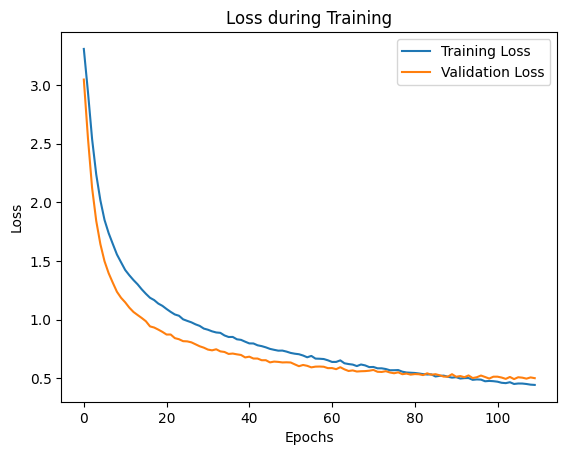

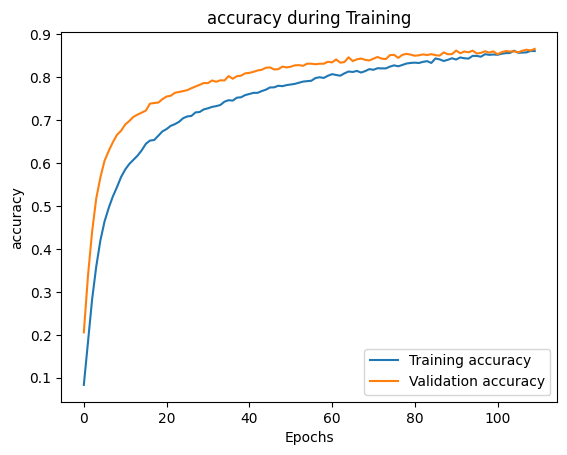

In [16]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

<Figure size 1200x1200 with 0 Axes>

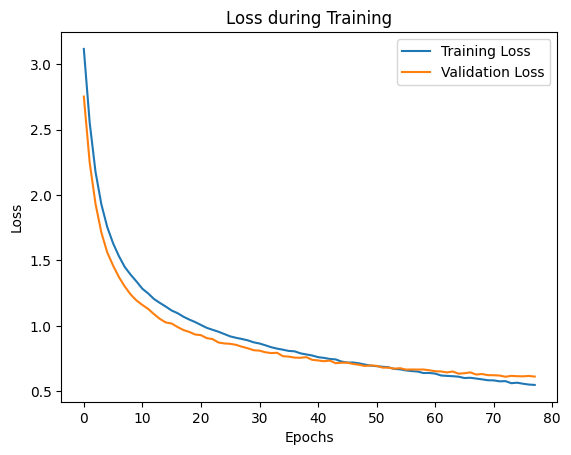

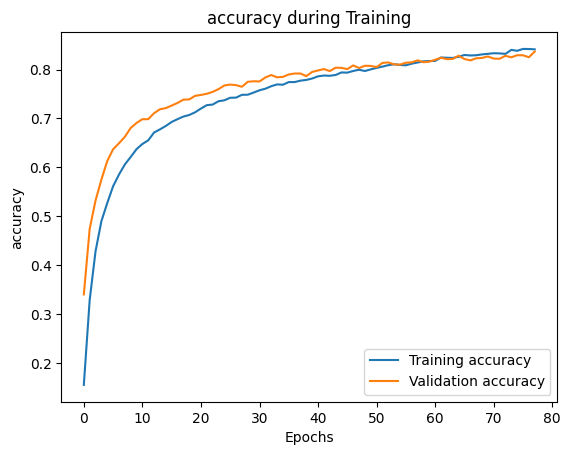

In [12]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

1/1 [==============================] - 2s 2s/step
Accuracy de validación: 0.86


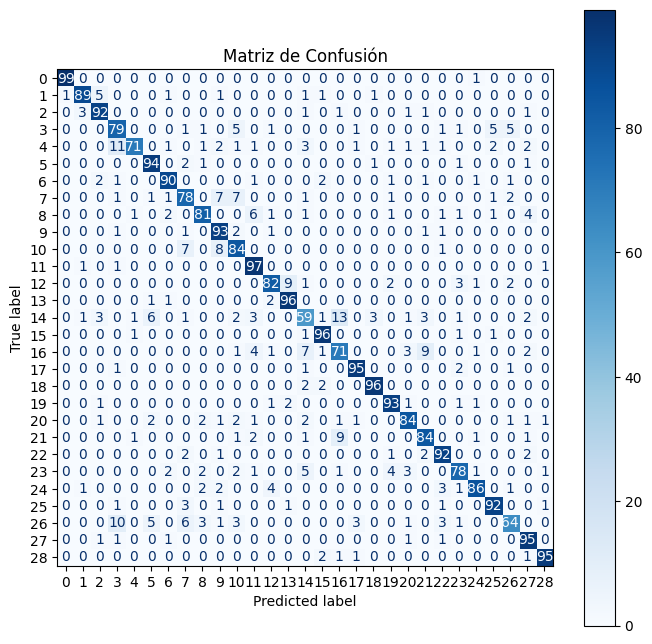

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in final_val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))  # Aumentar el tamaño de la figura
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de Confusión")
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy de validación: 0.83


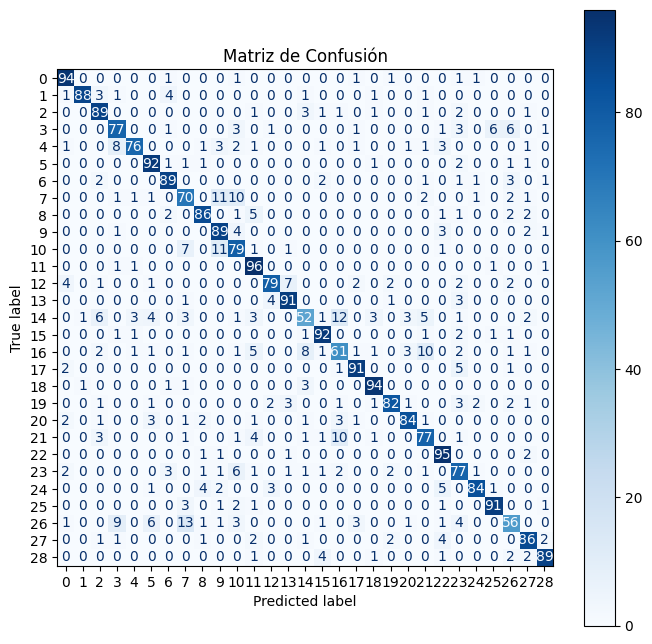

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in final_val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))  # Aumentar el tamaño de la figura
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de Confusión")
plt.show()

1/1 [==============================] - 0s 58ms/step


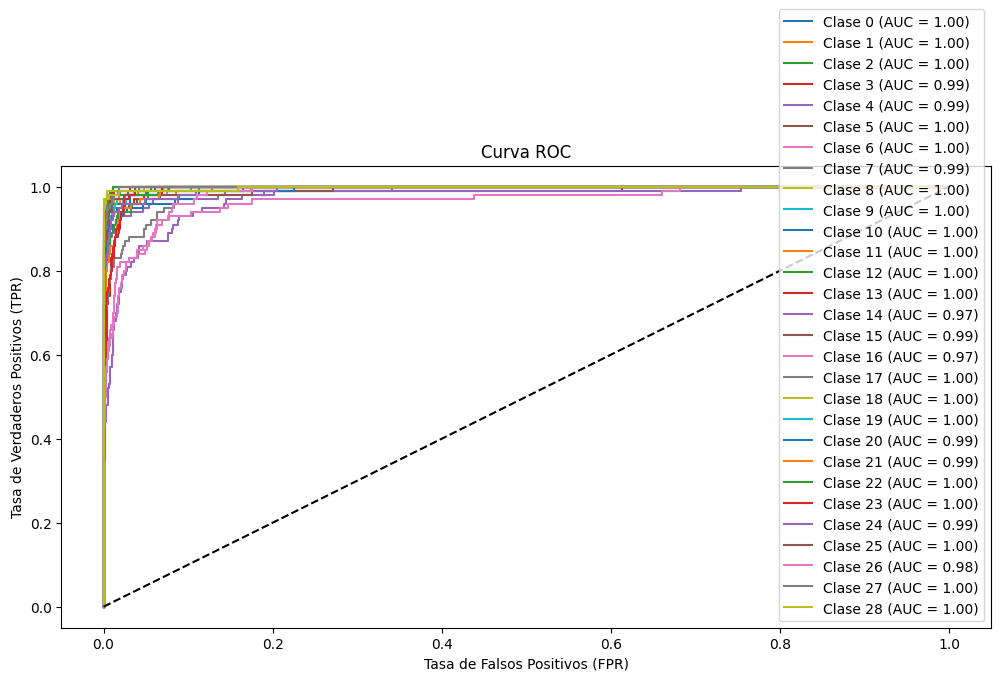

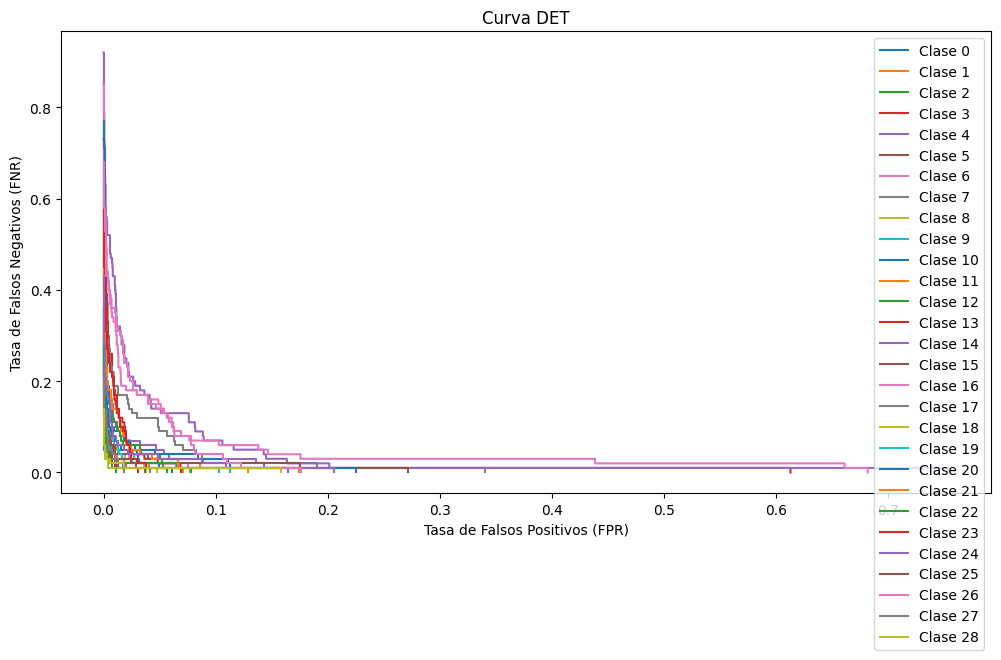

In [18]:
from sklearn.metrics import roc_curve, det_curve, auc
import keras
import matplotlib.pyplot as plt

# Convertir y_true y y_pred a formato binario para cada clase
y_true = []
y_pred = []

for images, labels in final_val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true_binary = keras.utils.to_categorical(y_true, num_classes=29)
y_pred_binary = np.array(y_pred)

# Generar la curva ROC y calcular el AUC para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva DET para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    # Verificar si hay más de una clase en y_true_binary[:, i]
    if len(np.unique(y_true_binary[:, i])) > 1:
        fpr, fnr, _ = det_curve(y_true_binary[:, i], y_pred_binary[:, i])
        plt.plot(fpr, fnr, label=f'Clase {i}')
    else:
        print(f"Clase {i} tiene solo una clase en y_true. No se puede generar la curva DET.")

plt.title('Curva DET')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Falsos Negativos (FNR)')
plt.legend(loc='upper right')
plt.show()